# 10. Data Summary for Multiple Regression

**metricsAI: An Introduction to Econometrics with Python and AI in the Cloud**

*[Carlos Mendez](https://carlos-mendez.org)*

<img src="https://raw.githubusercontent.com/quarcs-lab/metricsai/main/images/ch10_visual_summary.jpg" alt="Chapter 10 Visual Summary" width="65%">

This notebook provides an interactive introduction to multiple regression analysis. You'll learn how to work with multiple explanatory variables, interpret partial effects, assess model fit, and detect multicollinearity. All code runs directly in Google Colab without any local setup.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/quarcs-lab/metricsai/blob/main/notebooks_colab/ch10_Data_Summary_for_Multiple_Regression.ipynb)
<div class="chapter-resources">
<a href="https://www.youtube.com/watch?v=9398KshS_JA" target="_blank" class="resource-btn">🎬 AI Video</a>
<a href="https://carlos-mendez.my.canva.site/s10-data-summary-for-multiple-regression-pdf" target="_blank" class="resource-btn">✨ AI Slides</a>
<a href="https://cameron.econ.ucdavis.edu/aed/traedv1_10" target="_blank" class="resource-btn">📊 Cameron Slides</a>
<a href="https://app.edcafe.ai/quizzes/697868212f5d08069e04add5" target="_blank" class="resource-btn">✏️ Quiz</a>
<a href="https://app.edcafe.ai/chatbots/6978a0fd2f5d08069e0715f8" target="_blank" class="resource-btn">🤖 AI Tutor</a>
</div>


## Chapter Overview

This chapter extends bivariate regression to the more realistic case where we want to predict an outcome using **multiple explanatory variables** simultaneously. Multiple regression allows us to estimate the partial effect of each variable while controlling for others—a crucial feature for empirical economic analysis.

**Learning Objectives:**

By the end of this chapter, you will be able to:

1. Extend bivariate regression concepts to multiple regression with several regressors
2. Interpret pairwise correlations and use them for exploratory data analysis
3. Understand the ordinary least squares (OLS) method for multiple regression
4. Interpret partial effects: how one regressor affects $y$ while holding others constant
5. Distinguish between partial effects and total effects
6. Evaluate model fit using R-squared and adjusted R-squared
7. Understand information criteria (AIC, BIC) for model selection
8. Recognize when regression coefficients cannot be estimated (perfect collinearity)

**Dataset used:**

- **AED_HOUSE.DTA**: 29 houses sold in Davis, California (1999) with price, size, bedrooms, bathrooms, lot size, age, and month sold

**Key economic question:**
What is the effect of house size on price **after controlling** for other characteristics like bedrooms, bathrooms, and age?

**Chapter outline:**

- 10.1 Example: House Price and Characteristics
- 10.2 Two-Way Scatterplots
- 10.3 Correlation Analysis
- 10.4 Multiple Regression Estimation
- 10.5 Partial Effects — The FWL Theorem
- 10.6 Model Fit Statistics
- 10.7 Model Comparison
- 10.8 Inestimable Models and Multicollinearity
- Key Takeaways
- Practice Exercises
- Case Studies

**Estimated time:** 60-75 minutes

## Setup

First, we import the necessary Python packages and configure the environment for reproducibility. All data will stream directly from GitHub.

In [1]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import random
import os

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# GitHub data URL
GITHUB_DATA_URL = "https://raw.githubusercontent.com/quarcs-lab/data-open/master/AED/"

# Set plotting style (dark theme matching book design)
plt.style.use('dark_background')
sns.set_style("darkgrid")
plt.rcParams.update({
    'axes.facecolor': '#1a2235',
    'figure.facecolor': '#12162c',
    'grid.color': '#3a4a6b',
    'figure.figsize': (10, 6),
    'text.color': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'axes.edgecolor': '#1a2235',
})

print("Setup complete! Ready to analyze house price data.")

Setup complete! Ready to analyze house price data.


## 10.1: Example - House Price and Characteristics

We begin with a real estate dataset from Davis, California. Understanding house prices is a classic economic application because prices reflect both fundamental characteristics (size, bedrooms) and market conditions.

**The dataset contains:**

- **Price**: Sale price in dollars
- **Size**: House size in square feet
- **Bedrooms**: Number of bedrooms
- **Bathrooms**: Number of bathrooms
- **Lotsize**: Size of lot (1=small, 2=medium, 3=large)
- **Age**: House age in years
- **Monthsold**: Month of year house was sold

**Economic motivation:** A simple regression of price on bedrooms might find a positive relationship, but is this because bedrooms directly add value, or because houses with more bedrooms tend to be larger? Multiple regression helps us disentangle these effects.

In [2]:
# Load house price data
data_house = pd.read_stata(GITHUB_DATA_URL + 'AED_HOUSE.DTA')

# Display first few observations
print("First 10 observations:")
print(data_house[['price', 'size', 'bedrooms', 'bathrooms', 'lotsize', 'age', 'monthsold']].head(10))

# Display data summary
print("\nSummary statistics:")
print(data_house.describe())

First 10 observations:
    price  size  bedrooms  bathrooms  lotsize   age  monthsold
0  204000  1400         3        2.0        1  31.0          7
1  212000  1600         3        3.0        2  33.0          5
2  213000  1800         3        2.0        2  51.0          4
3  220000  1600         3        2.0        1  49.0          4
4  224500  2100         4        2.5        2  47.0          6
5  229000  1700         4        2.5        2  35.0          3
6  230000  2100         4        2.0        2  34.0          8
7  233000  1700         3        2.0        1  40.0          6
8  235000  1700         4        2.0        2  29.0          7
9  235000  1600         3        2.0        3  35.0          5

Summary statistics:
               price         size   bedrooms  bathrooms    lotsize        age  \
count      29.000000    29.000000  29.000000  29.000000  29.000000  29.000000   
mean   253910.344828  1882.758621   3.793103   2.206897   2.137931  36.413792   
std     37390.710695

### Bivariate vs. Multiple Regression

Let's compare a simple regression (price on bedrooms only) with a multiple regression (price on bedrooms AND size). This illustrates how controlling for other variables changes coefficient estimates.

**Key insight:** In the bivariate regression, the bedrooms coefficient captures both the direct effect of bedrooms and the indirect effect through correlation with size. In multiple regression, we isolate the **partial effect** of bedrooms holding size constant.

In [3]:
# Bivariate regression: price ~ bedrooms
model_bivariate = ols('price ~ bedrooms', data=data_house).fit()

print("=" * 70)
print("BIVARIATE REGRESSION: price ~ bedrooms")
print("=" * 70)
print(model_bivariate.summary())

# Multiple regression: price ~ bedrooms + size
model_multiple = ols('price ~ bedrooms + size', data=data_house).fit()

print("\n" + "=" * 70)
print("MULTIPLE REGRESSION: price ~ bedrooms + size")
print("=" * 70)
print(model_multiple.summary())

# Compare bedrooms coefficient
print("\n" + "=" * 70)
print("COEFFICIENT COMPARISON")
print("=" * 70)
print(f"Bedrooms coefficient (bivariate):  ${model_bivariate.params['bedrooms']:,.2f}")
print(f"Bedrooms coefficient (multiple):   ${model_multiple.params['bedrooms']:,.2f}")
print(f"Change: ${model_multiple.params['bedrooms'] - model_bivariate.params['bedrooms']:,.2f}")
print("\nThe coefficient drops dramatically because bedrooms was capturing size effects.")

BIVARIATE REGRESSION: price ~ bedrooms
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     6.030
Date:                Tue, 17 Feb 2026   Prob (F-statistic):             0.0208
Time:                        22:26:06   Log-Likelihood:                -343.06
No. Observations:                  29   AIC:                             690.1
Df Residuals:                      27   BIC:                             692.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1

> **Key Concept 10.1: Partial Effects vs. Total Effects in Multiple Regression**
>
> In bivariate regression, the bedrooms coefficient (\$23,667) captures both the direct effect of bedrooms and the indirect effect through correlation with size. In multiple regression, the bedrooms coefficient drops to \$1,553 — the **partial effect** holding size constant. This dramatic change illustrates why controlling for confounders is essential for isolating individual variable effects.

## 10.2: Two-Way Scatterplots

Before running multiple regression, it's useful to visualize pairwise relationships between variables. A **scatterplot matrix** shows all two-way scatterplots simultaneously.

**What to look for:**

- Strong linear relationships (potential predictors of price)
- Correlation between explanatory variables (potential multicollinearity)
- Outliers or non-linear patterns

The diagonal shows the distribution of each variable using kernel density estimates (KDE).

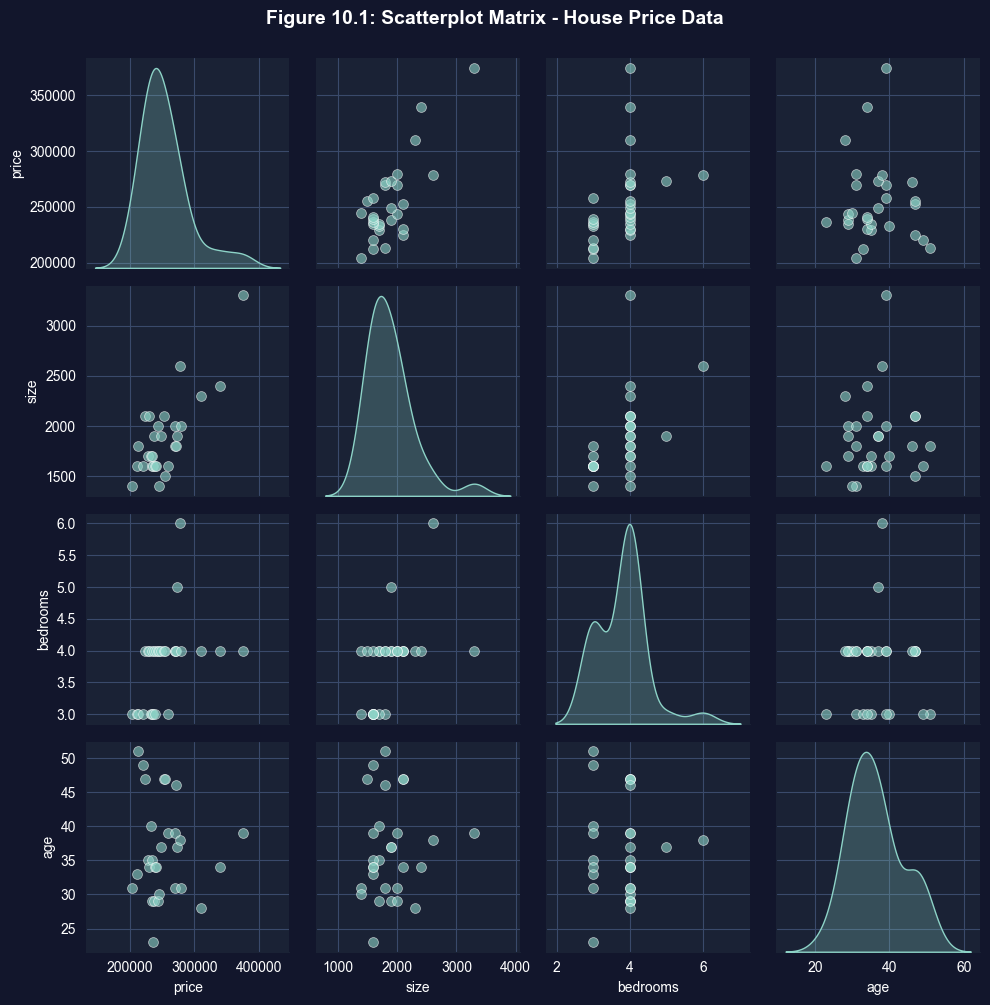

Scatterplot matrix created.
Notice: Price shows strongest relationship with Size.


In [4]:
# Create scatterplot matrix
plot_vars = ['price', 'size', 'bedrooms', 'age']
g = sns.pairplot(data_house[plot_vars], diag_kind='kde', plot_kws={'alpha': 0.6, 's': 50})
g.fig.suptitle('Figure 10.1: Scatterplot Matrix - House Price Data', 
               fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("Scatterplot matrix created.")
print("Notice: Price shows strongest relationship with Size.")

> **Key Concept 10.2: Exploratory Data Analysis with Scatterplot Matrices**
>
> Pairwise scatterplot matrices display all two-way relationships simultaneously, revealing linear associations, nonlinearities, clusters, and outliers before formal modeling. They also highlight potential multicollinearity: if two regressors are tightly correlated (e.g., size and bedrooms), their individual effects may be hard to separate in a regression.

## 10.3: Correlation Analysis

The **correlation coefficient** measures the strength of linear association between two variables, ranging from -1 (perfect negative) to +1 (perfect positive).

**Correlation matrix insights:**

- **Price is most correlated with Size** (r = 0.79), then Bedrooms (r = 0.43)
- **Size and Bedrooms are correlated** (r = 0.52), which can cause multicollinearity
- Correlation ≠ causation (merely shows association)

A correlation heatmap provides visual representation with color intensity showing strength of correlation.

Correlation Matrix:
              price      size  bedrooms  bathrooms   lotsize       age  \
price      1.000000  0.785782  0.427275   0.329793  0.153479 -0.068015   
size       0.785782  1.000000  0.517630   0.316338  0.112437  0.076925   
bedrooms   0.427275  0.517630  1.000000   0.037435  0.292206 -0.026140   
bathrooms  0.329793  0.316338  0.037435   1.000000  0.101575  0.037018   
lotsize    0.153479  0.112437  0.292206   0.101575  1.000000 -0.019220   
age       -0.068015  0.076925 -0.026140   0.037018 -0.019220  1.000000   
monthsold -0.209985 -0.214511  0.182512  -0.392310 -0.057140 -0.366207   

           monthsold  
price      -0.209985  
size       -0.214511  
bedrooms    0.182512  
bathrooms  -0.392310  
lotsize    -0.057140  
age        -0.366207  
monthsold   1.000000  


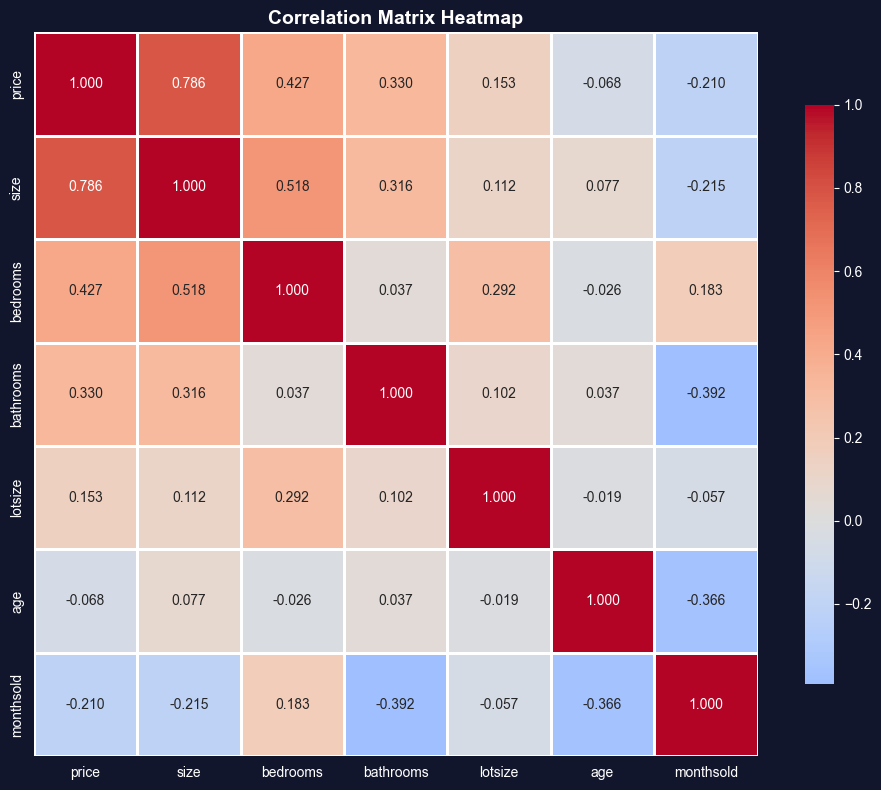


Key observations:
  - Price-Size correlation: 0.786 (strongest predictor)
  - Price-Bedrooms correlation: 0.427
  - Size-Bedrooms correlation: 0.518 (multicollinearity concern)


In [5]:
# Calculate correlation matrix
corr_vars = ['price', 'size', 'bedrooms', 'bathrooms', 'lotsize', 'age', 'monthsold']
corr_matrix = data_house[corr_vars].corr()

print("Correlation Matrix:")
print(corr_matrix)

# Visualize correlation matrix as heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
ax.set_title('Correlation Matrix Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey observations:")
print(f"  - Price-Size correlation: {corr_matrix.loc['price', 'size']:.3f} (strongest predictor)")
print(f"  - Price-Bedrooms correlation: {corr_matrix.loc['price', 'bedrooms']:.3f}")
print(f"  - Size-Bedrooms correlation: {corr_matrix.loc['size', 'bedrooms']:.3f} (multicollinearity concern)")

> **Key Concept 10.3: Correlation vs. Causation in Multivariate Analysis**
>
> High bivariate correlation (e.g., bedrooms-price, $r = 0.43$) may diminish or vanish after controlling for confounders. In our data, bedrooms correlate with price largely because bigger houses have more bedrooms. Multiple regression isolates each variable's partial contribution, revealing that size — not bedrooms — drives most of the price variation.

Having explored the data visually and through correlations, we now estimate the formal multiple regression model to quantify partial effects.

## 10.4: Multiple Regression Estimation

Now we estimate the **full multiple regression model** with all available predictors. The regression equation is:

$$\widehat{\text{price}} = b_1 + b_2 \times \text{size} + b_3 \times \text{bedrooms} + b_4 \times \text{bathrooms} + b_5 \times \text{lotsize} + b_6 \times \text{age} + b_7 \times \text{monthsold}$$

**Ordinary Least Squares (OLS)** chooses coefficients $b_1, ..., b_7$ to minimize the sum of squared residuals:

$$\min \sum_{i=1}^{n} (y_i - \widehat{y}_i)^2$$

where $y_i$ is the actual price and $\widehat{y}_i$ is the predicted price.

In [6]:
# Estimate full multiple regression model
model_full = ols('price ~ size + bedrooms + bathrooms + lotsize + age + monthsold',
                 data=data_house).fit()

print("=" * 70)
print("FULL MULTIPLE REGRESSION MODEL")
print("=" * 70)
print(model_full.summary())

FULL MULTIPLE REGRESSION MODEL
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     6.826
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           0.000342
Time:                        22:26:10   Log-Likelihood:                -330.74
No. Observations:                  29   AIC:                             675.5
Df Residuals:                      22   BIC:                             685.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.378e+05

### Coefficient Interpretation with Confidence Intervals

Each regression coefficient represents a **partial effect**: the expected change in price when that variable increases by one unit, **holding all other variables constant**.

**Example interpretation (Size coefficient):**

- Coefficient ≈ \$68.37 per square foot
- Interpretation: A one square foot increase in house size is associated with a \$68.37 increase in price, holding bedrooms, bathrooms, lot size, age, and month sold constant.

The 95% confidence interval tells us the range of plausible values for each coefficient.

In [7]:
# Display coefficients with 95% confidence intervals
conf_int = model_full.conf_int(alpha=0.05)
coef_table = pd.DataFrame({
    'Coefficient': model_full.params,
    'Std. Error': model_full.bse,
    'CI Lower': conf_int.iloc[:, 0],
    'CI Upper': conf_int.iloc[:, 1],
    't-statistic': model_full.tvalues,
    'p-value': model_full.pvalues
})

print("Coefficients with 95% Confidence Intervals:")
print(coef_table)

print("\nKey result: Size is the only statistically significant predictor (p < 0.05).")

Coefficients with 95% Confidence Intervals:
             Coefficient    Std. Error      CI Lower       CI Upper  \
Intercept  137791.065699  61464.951869  10320.557398  265261.573999   
size           68.369419     15.389472     36.453608     100.285230   
bedrooms     2685.315122   9192.525674 -16378.816300   21749.446543   
bathrooms    6832.880015  15721.191544 -25770.875723   39436.635753   
lotsize      2303.221371   7226.535205 -12683.695364   17290.138107   
age          -833.038602    719.334544  -2324.847139     658.769936   
monthsold   -2088.503625   3520.897859  -9390.398871    5213.391620   

           t-statistic   p-value  
Intercept     2.241783  0.035387  
size          4.442610  0.000205  
bedrooms      0.292119  0.772932  
bathrooms     0.434629  0.668065  
lotsize       0.318717  0.752947  
age          -1.158068  0.259254  
monthsold    -0.593174  0.559114  

Key result: Size is the only statistically significant predictor (p < 0.05).


> **Key Concept 10.4: Interpreting Partial Effects in Multiple Regression**
>
> Each coefficient $b_j$ measures the expected change in $y$ when $x_j$ increases by one unit, **holding all other regressors constant**. For example, a size coefficient of \$68.37 means each additional square foot is associated with a \$68.37 price increase, controlling for bedrooms, bathrooms, lot size, age, and month sold. Statistical significance is assessed through confidence intervals and $t$-tests.

## 10.5: Partial Effects - The FWL Theorem

The **Frisch-Waugh-Lovell (FWL) Theorem** states that the coefficient on any variable in multiple regression equals the coefficient from a bivariate regression of $y$ on the **residualized** version of that variable.

**Demonstration:**

1. Regress `size` on all other variables, obtain residuals $\widetilde{\text{size}}$
2. Regress `price` on $\widetilde{\text{size}}$ only
3. The coefficient will exactly match the `size` coefficient from the full multiple regression

**Intuition:** The residual $\widetilde{\text{size}}$ represents the variation in size that is **not explained** by other variables. This is why multiple regression isolates partial effects.

In [8]:
# Step 1: Regress size on all other variables
model_size_on_others = ols('size ~ bedrooms + bathrooms + lotsize + age + monthsold',
                            data=data_house).fit()
resid_size = model_size_on_others.resid

# Step 2: Regress price on residualized size
data_house['resid_size'] = resid_size
model_price_on_resid = ols('price ~ resid_size', data=data_house).fit()

# Compare coefficients
print("=" * 70)
print("DEMONSTRATION: FWL THEOREM (Partial Effects)")
print("=" * 70)
print(f"Size coefficient from FULL multiple regression:  {model_full.params['size']:.10f}")
print(f"Coefficient on residualized size (bivariate):    {model_price_on_resid.params['resid_size']:.10f}")
print(f"Difference (numerical precision):                 {abs(model_full.params['size'] - model_price_on_resid.params['resid_size']):.15f}")
print("\nThese coefficients are identical! This proves the partial effect interpretation.")

DEMONSTRATION: FWL THEOREM (Partial Effects)
Size coefficient from FULL multiple regression:  68.3694189767
Coefficient on residualized size (bivariate):    68.3694189767
Difference (numerical precision):                 0.000000000000057

These coefficients are identical! This proves the partial effect interpretation.


> **Key Concept 10.5: The Frisch-Waugh-Lovell (FWL) Theorem**
>
> The partial effect of $x_j$ in a multiple regression equals the slope from a bivariate regression of $y$ on $\widetilde{x}_j$, where $\widetilde{x}_j$ is the residual from regressing $x_j$ on all other regressors. Intuitively, $\widetilde{x}_j$ captures the variation in $x_j$ that is independent of the other variables — this is exactly what multiple regression uses to estimate partial effects.

Now that we understand partial effects and the FWL theorem, let's evaluate how well the overall regression model fits the data.

## 10.6: Model Fit Statistics

Several statistics summarize how well the regression model fits the data:

**R-squared ($R^2$):**

- Fraction of variation in $y$ explained by the regressors
- Formula: $R^2 = \frac{\text{Explained SS}}{\text{Total SS}} = 1 - \frac{\text{Residual SS}}{\text{Total SS}}$
- Range: 0 to 1 (higher is better fit)
- **Problem:** Always increases when adding variables (even irrelevant ones)

**Adjusted R-squared ($\bar{R}^2$):**

- Penalizes model complexity (number of parameters $k$)
- Formula: $\bar{R}^2 = 1 - \frac{\text{RSS}/(n-k)}{\text{TSS}/(n-1)}$
- Can decrease when adding unhelpful variables
- Preferred for model comparison

**Root MSE (Standard error of regression):**

- Typical size of prediction error
- Formula: $s_e = \sqrt{\frac{1}{n-k}\sum (y_i - \widehat{y}_i)^2}$
- Same units as $y$ (dollars in our case)

In [9]:
# Calculate and display model fit statistics
n = len(data_house)
k = len(model_full.params)  # includes intercept
df = n - k

print("=" * 70)
print("MODEL FIT STATISTICS")
print("=" * 70)
print(f"Sample size (n):               {n}")
print(f"Number of parameters (k):      {k}")
print(f"Degrees of freedom (n-k):      {df}")
print(f"\nR-squared:                     {model_full.rsquared:.6f}")
print(f"Adjusted R-squared:            {model_full.rsquared_adj:.6f}")
print(f"Root MSE:                      ${np.sqrt(model_full.mse_resid):,.2f}")

# Verify R² = [Corr(y, ŷ)]²
predicted = model_full.fittedvalues
corr_y_yhat = np.corrcoef(data_house['price'], predicted)[0, 1]
print(f"\nVerification: R² = [Corr(y, ŷ)]²")
print(f"  Correlation(y, ŷ):           {corr_y_yhat:.6f}")
print(f"  [Correlation(y, ŷ)]²:        {corr_y_yhat**2:.6f}")
print(f"  R² from model:                {model_full.rsquared:.6f}")
print(f"  Match: {np.isclose(corr_y_yhat**2, model_full.rsquared)}")

MODEL FIT STATISTICS
Sample size (n):               29
Number of parameters (k):      7
Degrees of freedom (n-k):      22

R-squared:                     0.650553
Adjusted R-squared:            0.555249
Root MSE:                      $24,935.73

Verification: R² = [Corr(y, ŷ)]²
  Correlation(y, ŷ):           0.806569
  [Correlation(y, ŷ)]²:        0.650553
  R² from model:                0.650553
  Match: True


### Information Criteria (AIC and BIC)

**Akaike Information Criterion (AIC)** and **Bayesian Information Criterion (BIC)** are more sophisticated measures that penalize model complexity:

$$\text{AIC} = n \times \ln(\widehat{\sigma}_e^2) + n(1 + \ln 2\pi) + 2k$$
$$\text{BIC} = n \times \ln(\widehat{\sigma}_e^2) + n(1 + \ln 2\pi) + k \times \ln(n)$$

**Key points:**

- **Lower values are better** (unlike R²)
- BIC penalizes complexity more heavily than AIC
- Useful for comparing non-nested models
- Different software packages may use different conventions (scaling by $n$)

In [10]:
# Calculate information criteria
print("=" * 70)
print("INFORMATION CRITERIA")
print("=" * 70)

# AIC and BIC from statsmodels
print(f"AIC (statsmodels):             {model_full.aic:.4f}")
print(f"BIC (statsmodels):             {model_full.bic:.4f}")

# Manual calculation (Stata convention)
rss = np.sum(model_full.resid ** 2)
aic_stata = n * np.log(rss/n) + n * (1 + np.log(2*np.pi)) + 2*k
bic_stata = n * np.log(rss/n) + n * (1 + np.log(2*np.pi)) + k*np.log(n)

print(f"\nAIC (Stata convention):        {aic_stata:.4f}")
print(f"BIC (Stata convention):        {bic_stata:.4f}")
print("\nNote: Different conventions yield different values, but ranking is consistent.")

INFORMATION CRITERIA
AIC (statsmodels):             675.4824
BIC (statsmodels):             685.0535

AIC (Stata convention):        675.4824
BIC (Stata convention):        685.0535

Note: Different conventions yield different values, but ranking is consistent.


> **Key Concept 10.6: Model Selection with Adjusted R-squared vs. Information Criteria**
>
> Adjusted $R^2$ penalizes complexity mildly by dividing sums of squares by degrees of freedom. Information criteria (AIC, BIC) impose stronger penalties: BIC = $n \ln(\hat{\sigma}_e^2) + k \ln(n)$. Smaller AIC/BIC values indicate better models. BIC is generally preferred because its penalty grows with sample size, favoring more parsimonious specifications.

## 10.7: Model Comparison

It's often useful to compare multiple model specifications side-by-side. Here we compare:

- **Simple model:** Price predicted by size only
- **Full model:** Price predicted by all variables

**Key comparison points:**

- How much does R² improve?
- Does adjusted R² improve (accounting for added complexity)?
- How do coefficient estimates change?

**Economic interpretation:** If adding 5 more variables only modestly improves fit, the simple model may be preferred (parsimony principle).

In [11]:
# Estimate simple model (size only)
model_simple = ols('price ~ size', data=data_house).fit()

# Create comparison table
print("=" * 70)
print("MODEL COMPARISON: Simple vs. Full")
print("=" * 70)

comparison_stats = pd.DataFrame({
    'Model': ['Simple (size only)', 'Full (all variables)'],
    'R²': [model_simple.rsquared, model_full.rsquared],
    'Adj R²': [model_simple.rsquared_adj, model_full.rsquared_adj],
    'AIC': [model_simple.aic, model_full.aic],
    'BIC': [model_simple.bic, model_full.bic],
    'N': [n, n]
})

print(comparison_stats.to_string(index=False))

print("\nInterpretation:")
print(f"  - R² increases from {model_simple.rsquared:.3f} to {model_full.rsquared:.3f} (+{model_full.rsquared - model_simple.rsquared:.3f})")
print(f"  - Adj R² DECREASES from {model_simple.rsquared_adj:.3f} to {model_full.rsquared_adj:.3f} ({model_full.rsquared_adj - model_simple.rsquared_adj:.3f})")
print("  - This suggests the added variables don't improve fit enough to justify complexity.")
print("  - Simple model may be preferred (parsimony principle).")

MODEL COMPARISON: Simple vs. Full
               Model       R²   Adj R²        AIC        BIC  N
  Simple (size only) 0.617453 0.603285 668.106844 670.841436 29
Full (all variables) 0.650553 0.555249 675.482401 685.053472 29

Interpretation:
  - R² increases from 0.617 to 0.651 (+0.033)
  - Adj R² DECREASES from 0.603 to 0.555 (-0.048)
  - This suggests the added variables don't improve fit enough to justify complexity.
  - Simple model may be preferred (parsimony principle).


> **Key Concept 10.7: The Parsimony Principle**
>
> Simpler models are preferred unless additional variables meaningfully improve fit. In our house price example, adding five variables beyond size barely increased $R^2$ (0.618 $\to$ 0.651) while adjusted $R^2$ actually fell (0.603 $\to$ 0.555). Check adjusted $R^2$, AIC, and BIC — if they don't improve, the simpler model is preferred.

Having compared models, we now turn to a critical pitfall: when regressors are too closely related to separate their individual effects.

## 10.8: Inestimable Models and Multicollinearity

**Perfect multicollinearity** occurs when one regressor is an exact linear combination of others. In this case, OLS cannot estimate all coefficients (the model is "inestimable").

**Example:** If we create `size_twice = 2 × size` and include both `size` and `size_twice` as regressors, the model is perfectly collinear.

**Variance Inflation Factor (VIF)** detects multicollinearity:

- VIF measures how much a variable's variance is inflated due to correlation with other regressors
- Formula: $VIF_j = \frac{1}{1 - R_j^2}$ where $R_j^2$ is from regressing $x_j$ on all other $x$'s
- **Rule of thumb:** VIF > 10 indicates problematic multicollinearity

**Consequences of high multicollinearity:**

- Large standard errors (imprecise estimates)
- Unstable coefficients (small data changes → big estimate changes)
- Difficulty interpreting individual effects

In [12]:
# Demonstrate perfect multicollinearity
print("=" * 70)
print("DEMONSTRATION: Perfect Multicollinearity")
print("=" * 70)

# Create a perfectly collinear variable
data_house['size_twice'] = 2 * data_house['size']

print("Creating variable: size_twice = 2 × size")
print("Attempting to estimate: price ~ size + size_twice + bedrooms\n")

try:
    model_collinear = ols('price ~ size + size_twice + bedrooms', data=data_house).fit()
    print("Model estimated (software automatically dropped one variable):")
    print(model_collinear.summary())
except Exception as e:
    print(f"Error: {type(e).__name__}")
    print(f"Message: {str(e)}")

DEMONSTRATION: Perfect Multicollinearity
Creating variable: size_twice = 2 × size
Attempting to estimate: price ~ size + size_twice + bedrooms

Model estimated (software automatically dropped one variable):
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     21.03
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           3.68e-06
Time:                        22:26:10   Log-Likelihood:                -332.03
No. Observations:                  29   AIC:                             670.1
Df Residuals:                      26   BIC:                             674.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
   

### Variance Inflation Factors (VIF)

Now let's calculate VIF for each variable in our full model to check for multicollinearity problems.

In [13]:
# Calculate VIF for each variable in the full model
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = data_house[['size', 'bedrooms', 'bathrooms', 'lotsize', 'age', 'monthsold']]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("=" * 70)
print("VARIANCE INFLATION FACTORS (VIF)")
print("=" * 70)
print(vif_data.to_string(index=False))
print("\nInterpretation:")
print("  - VIF > 10: Problematic multicollinearity")
print("  - VIF 5-10: Moderate multicollinearity")
print("  - VIF < 5: Low multicollinearity")

max_vif = vif_data['VIF'].max()
if max_vif > 10:
    print(f"\nWarning: Maximum VIF = {max_vif:.2f} indicates multicollinearity issues.")
elif max_vif > 5:
    print(f"\nNote: Maximum VIF = {max_vif:.2f} shows moderate multicollinearity.")
else:
    print(f"\nGood: Maximum VIF = {max_vif:.2f} - no serious multicollinearity detected.")

VARIANCE INFLATION FACTORS (VIF)
 Variable       VIF
     size 40.133832
 bedrooms 57.819254
bathrooms 34.741906
  lotsize 11.969605
      age 21.024092
monthsold 12.795557

Interpretation:
  - VIF > 10: Problematic multicollinearity
  - VIF 5-10: Moderate multicollinearity
  - VIF < 5: Low multicollinearity



> **Key Concept 10.8: Detecting Multicollinearity with VIF**
>
> The Variance Inflation Factor (VIF) quantifies how much a coefficient's variance is inflated due to correlation with other regressors. VIF$_j = 1/(1 - R_j^2)$, where $R_j^2$ is from regressing $x_j$ on all other regressors. A VIF above 5 suggests moderate concern; above 10 indicates severe multicollinearity that inflates standard errors and destabilizes estimates. Perfect collinearity (VIF $\to \infty$) makes coefficients inestimable.

### Visualization: Actual vs. Predicted Values

A plot of actual vs. predicted values helps visualize model fit. Points close to the 45-degree line indicate accurate predictions.

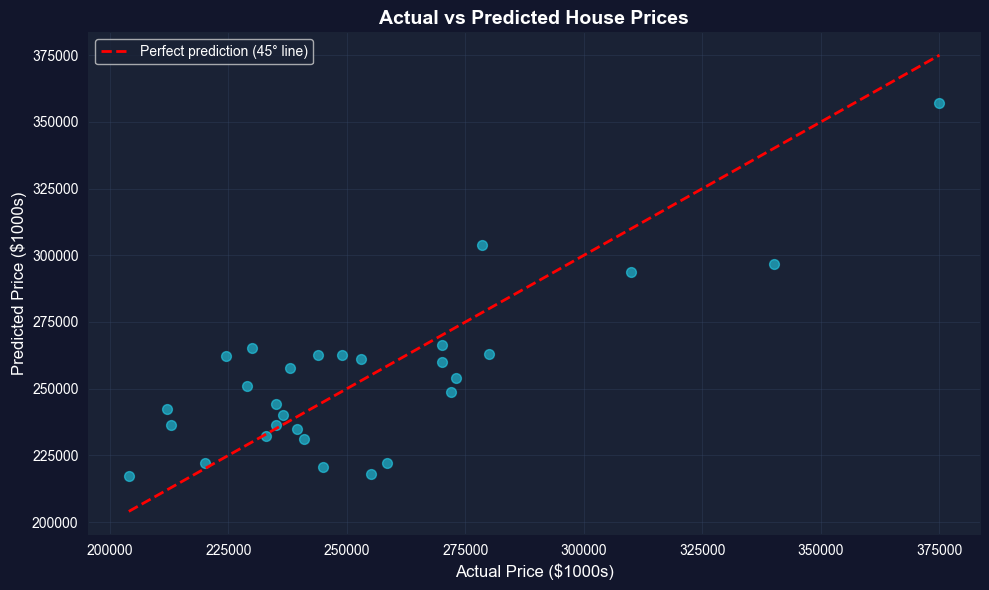

Points close to the red line indicate accurate predictions.


In [14]:
# Create actual vs predicted plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data_house['price'], model_full.fittedvalues, alpha=0.6, s=50, color='#22d3ee')
ax.plot([data_house['price'].min(), data_house['price'].max()],
        [data_house['price'].min(), data_house['price'].max()],
        'r--', linewidth=2, label='Perfect prediction (45° line)')
ax.set_xlabel('Actual Price ($1000s)', fontsize=12)
ax.set_ylabel('Predicted Price ($1000s)', fontsize=12)
ax.set_title('Actual vs Predicted House Prices', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Points close to the red line indicate accurate predictions.")

### Visualization: Residual Plot

A **residual plot** (residuals vs. fitted values) helps diagnose model problems:

- **Random scatter around zero:** Good (model assumptions satisfied)
- **Patterns (curves, funnels):** Bad (model misspecification or heteroskedasticity)
- **Outliers:** Investigate unusual observations

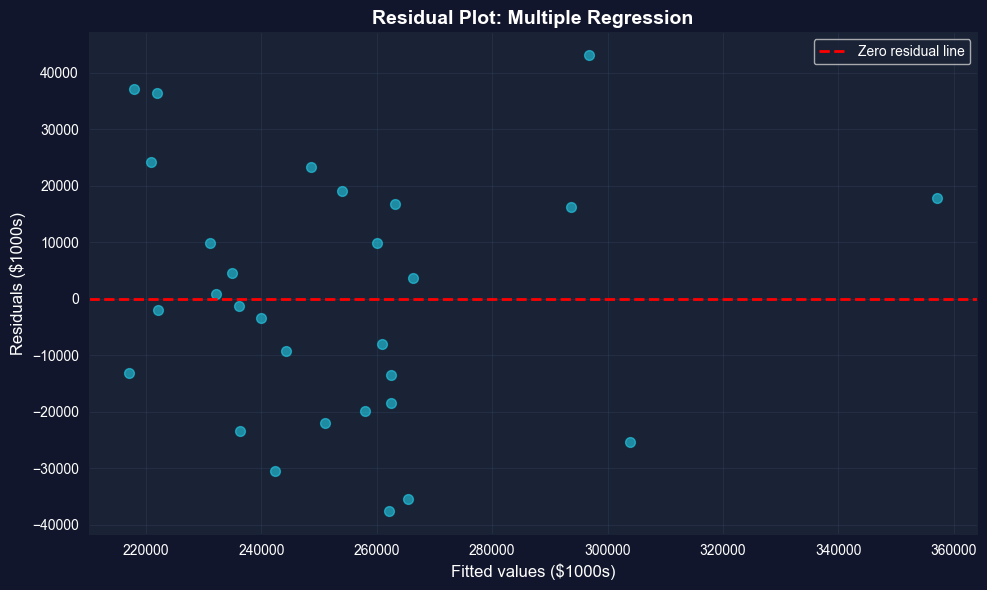

Random scatter around zero suggests model assumptions are reasonable.


In [15]:
# Create residual plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(model_full.fittedvalues, model_full.resid, alpha=0.6, s=50, color='#22d3ee')
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero residual line')
ax.set_xlabel('Fitted values ($1000s)', fontsize=12)
ax.set_ylabel('Residuals ($1000s)', fontsize=12)
ax.set_title('Residual Plot: Multiple Regression', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Random scatter around zero suggests model assumptions are reasonable.")

### Visualization: Coefficient Plot with Confidence Intervals

A **coefficient plot** displays estimated coefficients with their 95% confidence intervals. This makes it easy to see:

- Which coefficients are significantly different from zero (CI doesn't include zero)
- Relative magnitude of effects
- Precision of estimates (narrow vs. wide CIs)

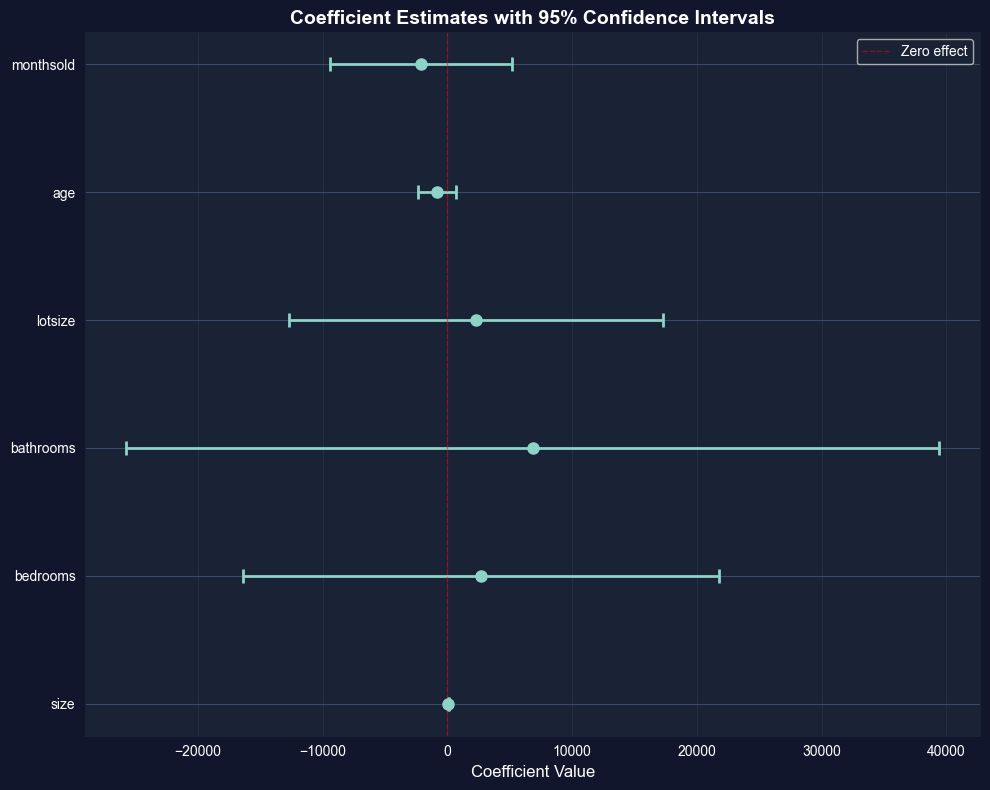

Coefficients whose CI crosses zero are not statistically significant.


In [16]:
# Create coefficient plot with confidence intervals
fig, ax = plt.subplots(figsize=(10, 8))

# Exclude intercept for better visualization
params_no_int = model_full.params[1:]
ci_no_int = conf_int.iloc[1:, :]

y_pos = np.arange(len(params_no_int))
ax.errorbar(params_no_int.values, y_pos,
            xerr=[params_no_int.values - ci_no_int.iloc[:, 0].values,
                  ci_no_int.iloc[:, 1].values - params_no_int.values],
            fmt='o', markersize=8, capsize=5, capthick=2, linewidth=2)
ax.set_yticks(y_pos)
ax.set_yticklabels(params_no_int.index)
ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Zero effect')
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_title('Coefficient Estimates with 95% Confidence Intervals',
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("Coefficients whose CI crosses zero are not statistically significant.")

## Key Takeaways

**Data Exploration and Correlation:**

- Multiple regression extends bivariate regression to include several regressors simultaneously
- Summary statistics and two-way scatterplots provide initial overview of variable relationships
- Correlation matrices reveal pairwise associations (e.g., price-size correlation of 0.79)
- Correlation can be misleading — bedrooms correlate with price, but may simply reflect house size

**OLS Estimation:**

- Multiple regression model: $\widehat{y} = b_1 + b_2 x_2 + b_3 x_3 + \cdots + b_k x_k$
- OLS minimizes the sum of squared residuals: $\min \sum (y_i - \widehat{y}_i)^2$
- The coefficient $b_j$ can be computed by bivariate regression of $y$ on $\widetilde{x}_j$ (residualized $x_j$)

**Partial Effects:**

- Each coefficient $b_j$ measures the partial effect: the change in $\widehat{y}$ when $x_j$ changes by one unit, **holding all other regressors constant**
- Partial effects differ from total effects (which allow other regressors to vary)
- OLS measures association, not causation — use careful language ("associated with")

**Model Fit:**

- $R^2$ measures the fraction of variation in $y$ explained by all regressors (0 to 1)
- Adjusted $R^2$ penalizes model complexity: can decrease when adding weak regressors
- Standard error of regression $s_e$ measures typical prediction error in units of $y$
- Example: Adding 5 regressors increased $R^2$ from 0.618 to 0.651 but decreased $\bar{R}^2$ from 0.603 to 0.555

**Information Criteria:**

- AIC, BIC, and HQIC penalize larger models more heavily than adjusted $R^2$
- Smaller values indicate better models
- BIC is generally preferred (stronger complexity penalty than AIC)

**Multicollinearity:**

- Perfect collinearity makes some coefficients inestimable (computer shows "omitted")
- VIF detects multicollinearity: VIF > 10 indicates problematic, VIF > 5 moderate concern
- High multicollinearity inflates standard errors and makes estimates unstable

**Python tools used:** `statsmodels` (OLS, VIF), `seaborn` (pairplot, heatmap), `pandas` (DataFrames), `matplotlib` (coefficient plots, diagnostics)

**Next steps:** Chapter 11 covers **statistical inference** for multiple regression — hypothesis tests, confidence intervals, and overall F-tests for model significance.

Congratulations on completing Chapter 10! You now have the tools to estimate and evaluate multiple regression models, a foundation for the rest of the course.

## Practice Exercises

Test your understanding of multiple regression concepts with these exercises.

---

**Exercise 1: Residuals and Fitted Values**

A regression leads to the fitted equation $\widehat{y} = 2 + 3x_2 + 4x_3$.

a) What is the predicted value for observation $(x_2, x_3) = (2, 1)$?

b) If the actual value is $y = 9$, what is the residual?

c) Is this observation over-predicted or under-predicted?

---

**Exercise 2: Partial vs. Total Effects**

Suppose OLS regression on the same dataset leads to:

- Bivariate: $\widehat{y} = 6 + 5x_2$
- Multiple: $\widehat{y} = 2 + 3x_2 + 4x_3$

a) Why does the coefficient on $x_2$ change from 5 to 3?

b) Which coefficient (5 or 3) represents the partial effect of $x_2$? Explain.

c) Under what condition would the bivariate and multiple regression coefficients on $x_2$ be equal?

---

**Exercise 3: R-squared and Adjusted R-squared**

OLS regression of $y$ on $x$ for a sample of size $n = 53$ leads to Residual SS = 20 and Total SS = 50.

a) Compute $R^2$.

b) Compute the standard error of the regression $s_e$.

c) Compute the correlation between $y$ and $\widehat{y}$.

d) If we add 3 more regressors and the Residual SS drops to 18, compute the new $R^2$ and adjusted $R^2$. Does the model improve?

---

**Exercise 4: Information Criteria**

Consider two models estimated on $n = 29$ observations:

- Model A (2 parameters): AIC = 668.1, BIC = 670.8
- Model B (7 parameters): AIC = 675.5, BIC = 685.1

a) Which model is preferred by AIC? By BIC?

b) Why does BIC penalize Model B more heavily than AIC?

c) What economic reasoning supports the simpler model in this case?

---

**Exercise 5: Multicollinearity Detection**

A multiple regression of house prices yields the following VIF values:

| Variable | VIF |
|----------|-----|
| Size | 40.1 |
| Bedrooms | 57.8 |
| Bathrooms | 34.7 |
| Age | 21.0 |

a) Which variables show the most severe multicollinearity?

b) What consequences does high VIF have for coefficient estimates and inference?

c) Suggest a strategy to reduce multicollinearity in this model.

---

**Exercise 6: Model Building**

You have data on employee wages with variables: education (years), experience (years), age, tenure (years at current firm), and gender.

a) Why might including both age and experience create multicollinearity?

b) Propose two alternative model specifications and explain the trade-offs.

c) How would you use adjusted $R^2$ and BIC to select the preferred specification?

## Case Studies

### Case Study 1: Multiple Regression for Cross-Country Productivity

In this case study, you will apply multiple regression techniques to investigate how human capital and physical capital jointly explain cross-country differences in labor productivity. Using data from 108 countries over 1990-2014, you will explore correlations, estimate multiple regression models, interpret partial effects, and compare model specifications.

**Dataset:** Mendez Convergence Clubs Data

- **Source:** Mendez (2020), 108 countries, 1990-2014
- **Key variables:**
  - `lp` — Labor productivity (GDP per worker)
  - `rk` — Physical capital per worker
  - `hc` — Human capital index
  - `rgdppc` — Real GDP per capita
  - `region` — Geographic region

**Research question:** How do human capital and physical capital jointly explain cross-country productivity differences?

```python
# Load the Mendez convergence clubs dataset
url = "https://raw.githubusercontent.com/quarcs-lab/mendez2020-convergence-clubs-code-data/master/assets/dat.csv"
dat = pd.read_csv(url)
dat_2014 = dat[dat['year'] == 2014].dropna(subset=['lp', 'rk', 'hc']).copy()
print(f"Cross-section sample: {len(dat_2014)} countries (year 2014)")
dat_2014.head()
```

#### Task 1: Explore Productivity Data (Guided)

Explore the cross-country productivity dataset.

```python
# Step 1: Create log-transformed variables
dat_2014['ln_lp'] = np.log(dat_2014['lp'])
dat_2014['ln_rk'] = np.log(dat_2014['rk'])

# Step 2: Summary statistics for key variables
print(dat_2014[['lp', 'rk', 'hc', 'ln_lp', 'ln_rk']].describe())

# Step 3: Create a scatterplot matrix
sns.pairplot(dat_2014[['ln_lp', 'ln_rk', 'hc']], diag_kind='kde')
plt.suptitle('Scatterplot Matrix: Productivity Variables', y=1.02)
plt.show()
```

**Questions:**

- Which variable shows the strongest visual association with $\ln(\text{lp})$?
- Do you see any nonlinear patterns or outliers?

#### Task 2: Correlation Analysis (Guided)

Compute and visualize the correlation matrix.

```python
# Step 1: Compute correlation matrix
corr = dat_2014[['ln_lp', 'ln_rk', 'hc']].corr()
print(corr)

# Step 2: Visualize as heatmap
sns.heatmap(corr, annot=True, fmt='.3f', cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix: Productivity Variables')
plt.show()
```

**Questions:**

- Which predictor is most strongly correlated with $\ln(\text{lp})$?
- Are $\ln(\text{rk})$ and hc correlated with each other? What implications does this have for multiple regression?

> **Key Concept 10.9: Functional Form and Cross-Country Comparisons**
>
> When comparing countries with vastly different income levels, logarithmic transformations are essential. Using $\ln(\text{lp})$ and $\ln(\text{rk})$ compresses the scale so that both Luxembourg and Malawi can be meaningfully compared. Coefficients on log-transformed variables have elasticity interpretations, while coefficients on level variables (like hc) represent semi-elasticities.

#### Task 3: Multiple Regression Estimation (Semi-guided)

Estimate bivariate and multiple regression models for labor productivity.

```python
# Model 1: ln(lp) ~ ln(rk) only
model1 = ols('ln_lp ~ ln_rk', data=dat_2014).fit()
print(model1.summary())

# Model 2: ln(lp) ~ hc only
model2 = ols('ln_lp ~ hc', data=dat_2014).fit()
print(model2.summary())

# Model 3: ln(lp) ~ ln(rk) + hc (multiple regression)
model3 = ols('ln_lp ~ ln_rk + hc', data=dat_2014).fit()
print(model3.summary())
```

**Questions:**

- How do the coefficients on $\ln(\text{rk})$ change between Model 1 and Model 3?
- Does adding human capital improve the model? Compare $R^2$ and adjusted $R^2$.

#### Task 4: Interpret Partial Effects (Semi-guided)

Interpret the coefficients from the multiple regression model.

```python
# Display coefficients with confidence intervals
print("Model 3 Coefficients:")
print(model3.params)
print("\n95% Confidence Intervals:")
print(model3.conf_int())
```

**Questions:**

- Interpret the coefficient on $\ln(\text{rk})$ in Model 3. What does it mean in economic terms?
- Interpret the coefficient on hc. How does a one-unit increase in human capital relate to productivity?
- Are both coefficients statistically significant? How do you know?

#### Task 5: Model Selection (Independent)

Compare models using fit statistics and information criteria.

**Your tasks:**

1. Create a comparison table with $R^2$, adjusted $R^2$, AIC, and BIC for all three models
2. Which model is preferred by adjusted $R^2$? By AIC? By BIC?
3. Does the parsimony principle favor one model over another?
4. Calculate VIF for Model 3 — is multicollinearity a concern?

*Hint: Use `model.rsquared`, `model.rsquared_adj`, `model.aic`, `model.bic` and `variance_inflation_factor()` from statsmodels.*

#### Task 6: Development Policy Brief (Independent)

Write a 200-300 word policy brief summarizing your findings.

**Your brief should address:**

1. What are the key determinants of cross-country labor productivity?
2. What is the relative importance of physical capital vs. human capital?
3. How do partial effects differ from bivariate associations?
4. What policy implications follow from your analysis?
5. What limitations should policymakers keep in mind (association vs. causation)?

> **Key Concept 10.10: Multiple Regression in Development Economics**
>
> Cross-country productivity regressions are central to development economics. By controlling for both physical capital ($\ln(\text{rk})$) and human capital (hc), we can assess each factor's **partial contribution** to productivity. This addresses a key policy question: should developing countries invest in machines or education? Multiple regression helps disentangle these effects, though causal claims require careful identification strategies.

### What You've Learned

In this case study, you applied the full multiple regression toolkit to cross-country productivity data:

- Explored data with scatterplot matrices and correlation analysis
- Estimated bivariate and multiple regression models, observing how coefficients change
- Interpreted partial effects of physical and human capital on productivity
- Compared model specifications using adjusted $R^2$, AIC, and BIC
- Connected statistical findings to development policy questions

These skills form the foundation for more advanced empirical analysis in the chapters ahead.

### Case Study 2: Multiple Satellite Predictors of Development

**Research Question**: Do satellite image embeddings improve our ability to predict municipal development beyond nighttime lights alone?

In Chapter 1, we introduced the DS4Bolivia project and estimated a bivariate regression of development on nighttime lights. Now we extend this analysis using Chapter 10's **multiple regression** tools, adding satellite image embeddings as additional predictors to test whether they improve our ability to predict municipal development.

**Background**: Nighttime lights (NTL) are a well-established proxy for economic activity, but they capture only one dimension of a municipality's characteristics — nocturnal luminosity. Daytime satellite imagery contains far richer information: building density, road networks, agricultural patterns, vegetation cover. Deep learning models can extract this information as **64-dimensional embedding vectors**, where each dimension captures abstract visual patterns learned automatically from the data.

**The key question for multiple regression**: Does adding these satellite embeddings as extra regressors significantly improve explanatory power compared to NTL alone? And if so, which embeddings matter most?

**Variables for this case study:**

- `imds` — Municipal Sustainable Development Index (0-100, outcome variable)
- `ln_NTLpc2017` — Log nighttime lights per capita (established predictor from Chapter 1)
- `A00`, `A10`, `A20`, `A30`, `A40` — Selected satellite image embedding dimensions (new predictors)
- `mun`, `dep` — Municipality and department identifiers

**Your Task**: Use correlation analysis, multiple regression, the FWL theorem, and model comparison tools from Chapter 10 to evaluate whether satellite embeddings add predictive value beyond nighttime lights.

#### Load the DS4Bolivia Data

Let's load the DS4Bolivia dataset and select the variables needed for our multiple regression analysis. We focus on the development index, nighttime lights, and five selected satellite embedding dimensions.

In [17]:
# Load the DS4Bolivia dataset
url_bol = "https://raw.githubusercontent.com/quarcs-lab/ds4bolivia/master/ds4bolivia_v20250523.csv"
bol = pd.read_csv(url_bol)

# Select key variables for this case study
key_vars = ['mun', 'dep', 'imds', 'ln_NTLpc2017', 'A00', 'A10', 'A20', 'A30', 'A40']
bol_sat = bol[key_vars].copy()

print("=" * 70)
print("DS4BOLIVIA DATASET — SATELLITE PREDICTORS")
print("=" * 70)
print(f"Dataset shape: {bol_sat.shape[0]} municipalities, {bol_sat.shape[1]} variables")
print(f"Departments: {bol['dep'].nunique()} unique departments")
print(f"Complete cases: {bol_sat.dropna().shape[0]}")
print("\n" + "=" * 70)
print("FIRST 10 MUNICIPALITIES")
print("=" * 70)
print(bol_sat.head(10).to_string(index=False))

KeyError: "['A00', 'A10', 'A20', 'A30', 'A40'] not in index"

#### Task 1: Explore Variables (Guided)

**Objective**: Understand the satellite embedding variables and how they compare to nighttime lights.

**Instructions**:

1. Generate summary statistics for all predictor variables using `describe()`
2. Compare the scale and distribution of NTL vs. embedding variables
3. Check for missing values across all selected variables
4. Consider: What are satellite embeddings? How do they differ from NTL?

**Key insight**: Unlike NTL (which has a clear physical interpretation — light intensity), embedding dimensions are **abstract features** extracted by neural networks. Dimension `A00` doesn't mean "vegetation" or "roads" — it captures a learned combination of visual patterns.

In [18]:
# Your code here: Explore the satellite predictor variables
#
# Step 1: Summary statistics for all numeric variables
print("=" * 70)
print("DESCRIPTIVE STATISTICS: DEVELOPMENT AND SATELLITE PREDICTORS")
print("=" * 70)
print(bol_sat[['imds', 'ln_NTLpc2017', 'A00', 'A10', 'A20', 'A30', 'A40']].describe().round(3))

# Step 2: Check for missing values
print("\n" + "=" * 70)
print("MISSING VALUES")
print("=" * 70)
print(bol_sat.isnull().sum())

# Step 3: Compare variable ranges
print("\n" + "=" * 70)
print("VARIABLE RANGES")
print("=" * 70)
for var in ['imds', 'ln_NTLpc2017', 'A00', 'A10', 'A20', 'A30', 'A40']:
    col = bol_sat[var].dropna()
    print(f"  {var:16s}  range: [{col.min():.3f}, {col.max():.3f}]  std: {col.std():.3f}")

DESCRIPTIVE STATISTICS: DEVELOPMENT AND SATELLITE PREDICTORS


NameError: name 'bol_sat' is not defined

#### Task 2: Correlation Analysis (Guided)

**Objective**: Compute and visualize the correlation structure among all predictors and the outcome variable.

**Instructions**:

1. Compute the correlation matrix for `imds`, `ln_NTLpc2017`, and all five embedding variables
2. Display the correlation matrix as a heatmap
3. Identify: Which embeddings correlate most strongly with `imds`?
4. Identify: Do the embeddings correlate with each other (potential multicollinearity)?
5. Do the embeddings correlate with NTL, or do they capture different information?

**Apply what you learned in section 10.3**: Use `seaborn.heatmap()` with annotated correlation values.

In [19]:
# Your code here: Correlation analysis of satellite predictors
#
# Step 1: Compute correlation matrix
corr_vars = ['imds', 'ln_NTLpc2017', 'A00', 'A10', 'A20', 'A30', 'A40']
corr_sat = bol_sat[corr_vars].dropna().corr()

print("=" * 70)
print("CORRELATION MATRIX: DEVELOPMENT AND SATELLITE PREDICTORS")
print("=" * 70)
print(corr_sat.round(3))

# Step 2: Visualize as heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_sat, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
ax.set_title('Correlation Matrix: IMDS, NTL, and Satellite Embeddings',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Step 3: Highlight strongest correlations with IMDS
print("\nCorrelations with IMDS (development index):")
imds_corr = corr_sat['imds'].drop('imds').sort_values(key=abs, ascending=False)
for var, r in imds_corr.items():
    print(f"  {var:16s}  r = {r:+.3f}")

NameError: name 'bol_sat' is not defined

> **Key Concept 10.12: High-Dimensional Satellite Features**
>
> Satellite embeddings are **64 abstract features** extracted by deep learning models (convolutional neural networks) from daytime satellite imagery. Unlike handcrafted variables (e.g., NDVI for vegetation), each embedding dimension captures complex visual patterns — road density, building structures, agricultural layouts — learned automatically from the data. These features are not directly interpretable (dimension A00 doesn't have a specific meaning), but they collectively encode rich information about a municipality's physical landscape.

#### Task 3: Multiple Regression (Semi-guided)

**Objective**: Estimate a multiple regression model with NTL and satellite embeddings as predictors.

**Instructions**:

1. Estimate the full model: `imds ~ ln_NTLpc2017 + A00 + A10 + A20 + A30 + A40`
2. Display the regression summary
3. Compare $R^2$ with the bivariate NTL-only model from Chapter 1
4. Interpret: How much does adding embeddings improve explanatory power?
5. Which embedding coefficients are statistically significant?

**Apply what you learned in section 10.4**: Use `ols()` from statsmodels and interpret partial effects.

In [20]:
# Your code here: Multiple regression with satellite predictors
#
# Step 1: Prepare data (drop missing values)
reg_data = bol_sat[['imds', 'ln_NTLpc2017', 'A00', 'A10', 'A20', 'A30', 'A40']].dropna()
print(f"Regression sample: {len(reg_data)} municipalities (complete cases)")

# Step 2: Bivariate model (NTL only — baseline from Chapter 1)
model_ntl = ols('imds ~ ln_NTLpc2017', data=reg_data).fit()
print("\n" + "=" * 70)
print("MODEL 1: BIVARIATE — imds ~ ln_NTLpc2017")
print("=" * 70)
print(model_ntl.summary())

# Step 3: Multiple regression (NTL + all 5 embeddings)
model_full_sat = ols('imds ~ ln_NTLpc2017 + A00 + A10 + A20 + A30 + A40',
                     data=reg_data).fit()
print("\n" + "=" * 70)
print("MODEL 2: MULTIPLE — imds ~ ln_NTLpc2017 + A00 + A10 + A20 + A30 + A40")
print("=" * 70)
print(model_full_sat.summary())

# Step 4: Compare R-squared
print("\n" + "=" * 70)
print("R-SQUARED COMPARISON")
print("=" * 70)
print(f"NTL only:           R² = {model_ntl.rsquared:.4f}")
print(f"NTL + 5 embeddings: R² = {model_full_sat.rsquared:.4f}")
print(f"Improvement:        ΔR² = {model_full_sat.rsquared - model_ntl.rsquared:.4f}")

NameError: name 'bol_sat' is not defined

#### Task 4: Partial Effects via FWL (Semi-guided)

**Objective**: Demonstrate the Frisch-Waugh-Lovell theorem by showing that the NTL coefficient in the multiple regression equals the coefficient from regressing residualized IMDS on residualized NTL.

**Instructions**:

1. Regress `imds` on all embedding variables (`A00`, `A10`, `A20`, `A30`, `A40`), save residuals $e_y$
2. Regress `ln_NTLpc2017` on all embedding variables, save residuals $e_x$
3. Regress $e_y$ on $e_x$ (bivariate regression of residuals)
4. Verify that the coefficient matches the NTL coefficient from the full multiple regression

**Apply what you learned in section 10.5**: This demonstrates that the partial effect of NTL is computed from the variation in NTL that is *independent* of the satellite embeddings.

In [21]:
# Your code here: FWL theorem demonstration
#
# Step 1: Regress imds on embeddings only, save residuals e_y
model_y_on_emb = ols('imds ~ A00 + A10 + A20 + A30 + A40', data=reg_data).fit()
e_y = model_y_on_emb.resid

# Step 2: Regress ln_NTLpc2017 on embeddings only, save residuals e_x
model_x_on_emb = ols('ln_NTLpc2017 ~ A00 + A10 + A20 + A30 + A40', data=reg_data).fit()
e_x = model_x_on_emb.resid

# Step 3: Regress e_y on e_x
fwl_data = pd.DataFrame({'e_y': e_y, 'e_x': e_x})
model_fwl = ols('e_y ~ e_x', data=fwl_data).fit()

# Step 4: Compare coefficients
print("=" * 70)
print("FWL THEOREM DEMONSTRATION")
print("=" * 70)
print(f"NTL coefficient from FULL multiple regression:  {model_full_sat.params['ln_NTLpc2017']:.10f}")
print(f"Coefficient from FWL residual regression:       {model_fwl.params['e_x']:.10f}")
print(f"Difference (numerical precision):                {abs(model_full_sat.params['ln_NTLpc2017'] - model_fwl.params['e_x']):.15f}")
print("\nThe coefficients are identical — confirming the FWL theorem!")
print("\nInterpretation: The partial effect of NTL on IMDS is computed using")
print("only the variation in NTL that is NOT explained by the satellite embeddings.")

NameError: name 'reg_data' is not defined

#### Task 5: Model Comparison (Independent)

**Objective**: Compare multiple model specifications using fit statistics and information criteria.

**Your tasks**:

1. Estimate three models:
   - **Model 1**: `imds ~ ln_NTLpc2017` (NTL only)
   - **Model 2**: `imds ~ ln_NTLpc2017 + A00 + A10` (NTL + 2 embeddings)
   - **Model 3**: `imds ~ ln_NTLpc2017 + A00 + A10 + A20 + A30 + A40` (NTL + 5 embeddings)

2. Create a comparison table reporting $R^2$, adjusted $R^2$, AIC, and BIC for each model
3. Use `model.rsquared`, `model.rsquared_adj`, `model.aic`, `model.bic`
4. Which model is "best" by each criterion?
5. Does the parsimony principle favor fewer or more embedding variables?

*Hint: Use `pd.DataFrame()` to create a clean comparison table.*

In [22]:
# Your code here: Model comparison
#
# Step 1: Estimate three models
# model_1 = ols('imds ~ ln_NTLpc2017', data=reg_data).fit()
# model_2 = ols('imds ~ ln_NTLpc2017 + A00 + A10', data=reg_data).fit()
# model_3 = ols('imds ~ ln_NTLpc2017 + A00 + A10 + A20 + A30 + A40', data=reg_data).fit()
#
# Step 2: Create comparison table
# comparison = pd.DataFrame({
#     'Model': ['NTL only', 'NTL + 2 embeddings', 'NTL + 5 embeddings'],
#     'R²': [model_1.rsquared, model_2.rsquared, model_3.rsquared],
#     'Adj R²': [model_1.rsquared_adj, model_2.rsquared_adj, model_3.rsquared_adj],
#     'AIC': [model_1.aic, model_2.aic, model_3.aic],
#     'BIC': [model_1.bic, model_2.bic, model_3.bic],
#     'N': [len(reg_data)] * 3
# })
# print(comparison.to_string(index=False))
#
# Step 3: Interpret — which model is preferred by each criterion?

> **Key Concept 10.13: Incremental Predictive Power**
>
> When adding predictors to a regression model, $R^2$ can only increase or stay the same — it never decreases. This makes $R^2$ misleading for model comparison when models have different numbers of predictors. **Adjusted $R^2$** penalizes for additional variables, while **AIC** and **BIC** balance fit against complexity. In the satellite prediction context, adding all 64 embeddings would maximize $R^2$ but might overfit; information criteria help identify the most parsimonious model.

#### Task 6: Policy Brief on Satellite Prediction (Independent)

**Objective**: Write a 200-300 word policy brief summarizing the value of satellite embeddings for development prediction.

**Your brief should address:**

1. **Improvement**: How much does adding satellite embeddings improve development prediction compared to NTL alone?
2. **Complexity trade-off**: Is the improvement worth the added model complexity? What do adjusted $R^2$, AIC, and BIC suggest?
3. **Partial effects**: After controlling for embeddings, does NTL remain a significant predictor? What does the FWL theorem reveal about NTL's independent contribution?
4. **SDG monitoring implications**: How could multi-source satellite data enhance SDG monitoring in data-scarce countries like Bolivia?
5. **Limitations**: What can satellite data *not* capture about development? What are the risks of relying on abstract embedding features for policy decisions?

**Connection to Research**: The DS4Bolivia project uses all 64 embedding dimensions plus machine learning methods (Random Forest, XGBoost) to predict SDG indicators, achieving meaningful predictive accuracy. Your multiple regression analysis provides a transparent, interpretable baseline for comparison.

In [23]:
# Your code here: Additional analysis for the policy brief
#
# You might want to:
# 1. Create a summary table of key results across models
# 2. Generate a visualization comparing model fit
# 3. Calculate the percentage improvement in R² from adding embeddings
# 4. Discuss which embeddings contribute most to prediction
#
# Example:
# print("KEY RESULTS FOR POLICY BRIEF")
# print(f"NTL-only R²:          {model_1.rsquared:.4f}")
# print(f"NTL + 5 embed R²:     {model_3.rsquared:.4f}")
# print(f"R² improvement:       {(model_3.rsquared - model_1.rsquared) / model_1.rsquared * 100:.1f}%")
# print(f"NTL coef (bivariate): {model_1.params['ln_NTLpc2017']:.4f}")
# print(f"NTL coef (multiple):  {model_3.params['ln_NTLpc2017']:.4f}")

#### What You've Learned from This Case Study

Through this analysis of multiple satellite predictors of Bolivian municipal development, you've applied the full Chapter 10 toolkit to a cutting-edge research application:

- **Correlation analysis**: Explored the correlation structure among NTL, satellite embeddings, and development outcomes
- **Multiple regression**: Estimated models with multiple satellite predictors and interpreted partial effects
- **FWL theorem**: Demonstrated that the partial effect of NTL equals the coefficient from regressing residualized IMDS on residualized NTL
- **Model comparison**: Evaluated competing specifications using $R^2$, adjusted $R^2$, AIC, and BIC
- **Critical assessment**: Weighed the predictive gains from additional satellite features against model complexity

**Connection to upcoming chapters**: In Chapter 11, we'll test whether the satellite embeddings are *statistically* significant using F-tests for joint significance. In Chapter 12, we'll address robust inference and prediction intervals.

**This dataset returns throughout the textbook**: Each subsequent chapter applies its specific econometric tools to the DS4Bolivia data, building progressively toward a comprehensive satellite-based development prediction framework.

---

**Well done!** You've now analyzed how multiple satellite data sources can predict development outcomes, moving from simple bivariate regression (Chapter 1) to the richer multiple regression framework of Chapter 10.